<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/simple-autoencoders/fc_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

True


In [3]:
root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
num_epochs=15
learning_rate=1e-3
batch_size=1024
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [5]:
class FCAE(nn.Module):
  def __init__(self):
    super(FCAE,self).__init__()
    self.encoder=nn.Sequential(
        nn.Linear(784,512),nn.ReLU(),
        nn.Linear(512,256),nn.ReLU(),
        nn.Linear(256,64),nn.ReLU(),
        nn.Linear(64,16),nn.ReLU(),
        nn.Linear(16,4)
    )
    self.decoder=nn.Sequential(
        nn.Linear(4,16),nn.ReLU(),
        nn.Linear(16,64),nn.ReLU(),
        nn.Linear(64,256),nn.ReLU(),
        nn.Linear(256,512),nn.ReLU(),
        nn.Linear(512,784),nn.Sigmoid()
    )
  def encode(self,input):
    input=input.reshape(-1,784)
    features=self.encoder(input.float())
    return features
  def decode(self,features):
    reconstruction=self.decoder(features)
    reconstruction=reconstruction.reshape(-1,1,28,28)
    return reconstruction
  def forward(self,x):
    output=self.encode(x)
    output=self.decode(output)
    return output

In [9]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  lossfn=torch.nn.BCELoss()
  model.train()
  for epoch in range(num_epochs):
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output=model.forward(images)
      loss=lossfn(output,images.float())
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    tens=[]
    tens_reconstr=[]
    plt.subplots(figsize=(50, 5))
    nos=[1,128,12370,111,2,244,44444,54695,14831,2299]
    for i in range(10):
      tens.append(training_set[nos[i]][0].reshape(-1,1,28,28))
      #tens1=torch.rand(1,1,28,28)*0.1
      #test1=np.squeeze(tens[i].numpy())
      with torch.no_grad():
        out=model.forward(tens[i].to(device))
        tens_reconstr.append(out)
        #test_reconstr=np.squeeze(tens_reconstr[i].cpu().numpy())
      #fig, (ax1, ax2) = plt.subplots(1, 2)
      plt.subplot(1,20,2*i+1)
      plt.imshow(np.squeeze(tens[i].numpy()))
      plt.subplot(1,20,2*i+2)
      plt.imshow(np.squeeze(tens_reconstr[i].cpu().numpy()))
    plt.pause(1e-10)
  return losses


In [10]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

Epoch [1/15], Loss: 0.1912


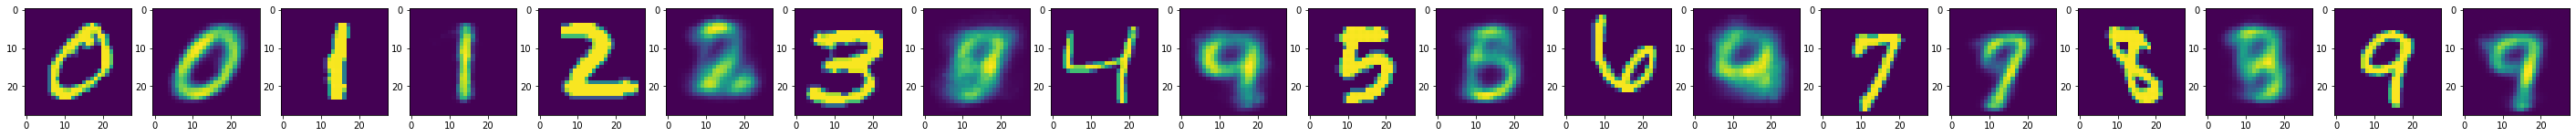

Epoch [2/15], Loss: 0.1666


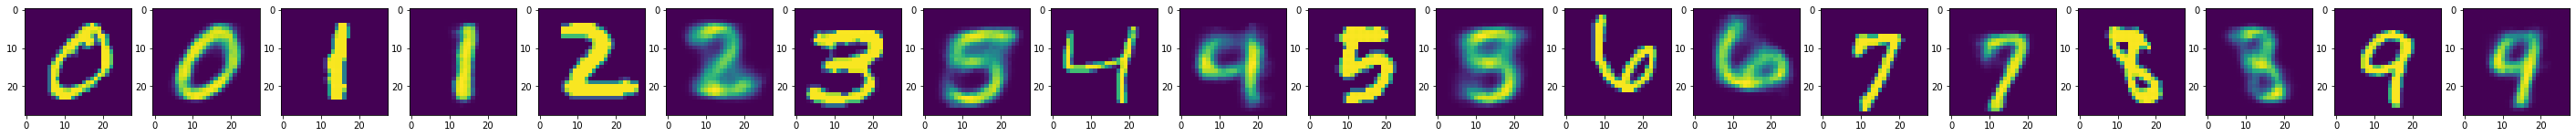

Epoch [3/15], Loss: 0.1558


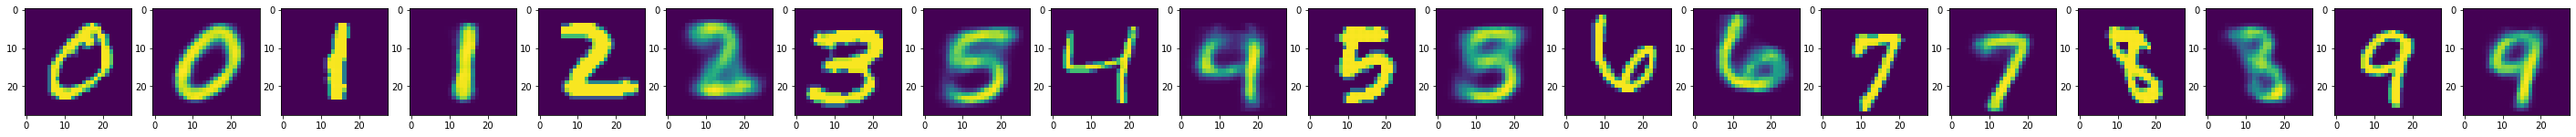

Epoch [4/15], Loss: 0.1505


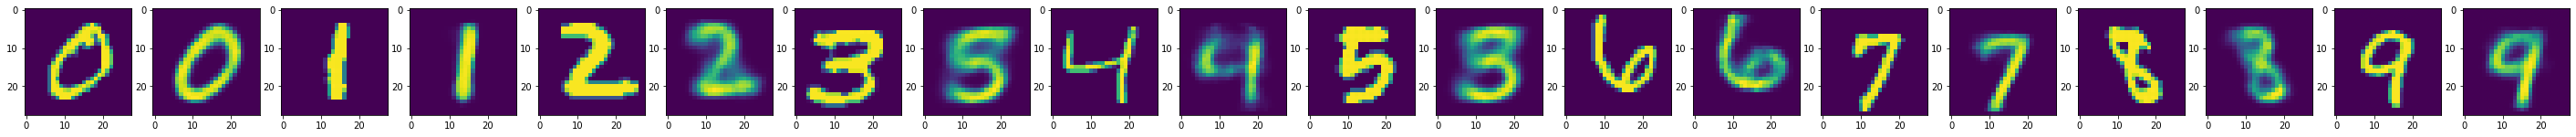

Epoch [5/15], Loss: 0.1491


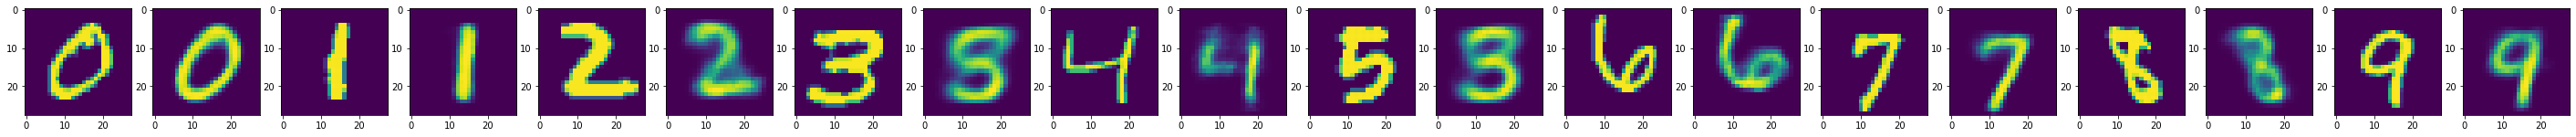

Epoch [6/15], Loss: 0.1470


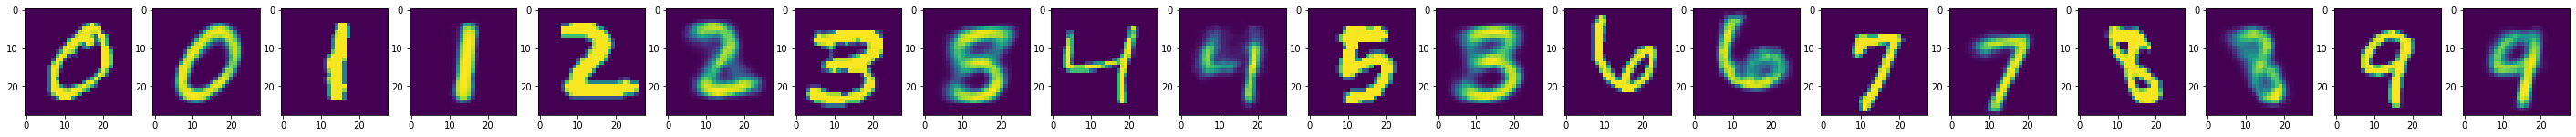

Epoch [7/15], Loss: 0.1447


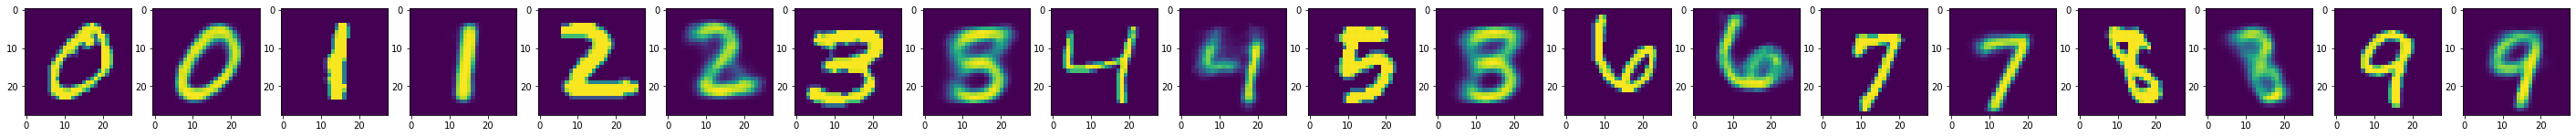

Epoch [8/15], Loss: 0.1441


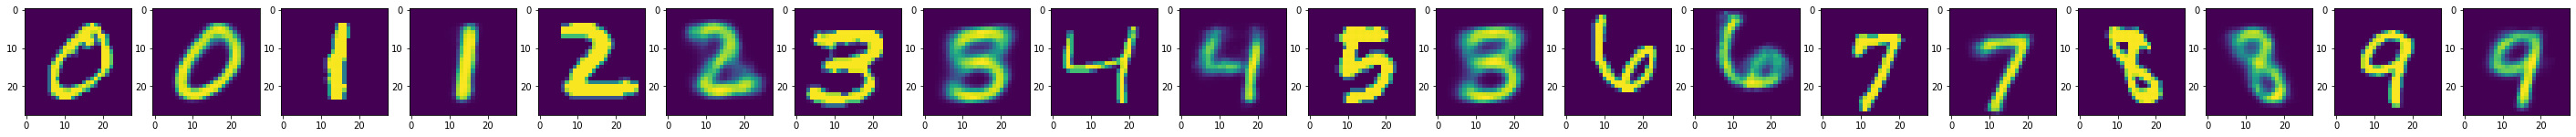

Epoch [9/15], Loss: 0.1491


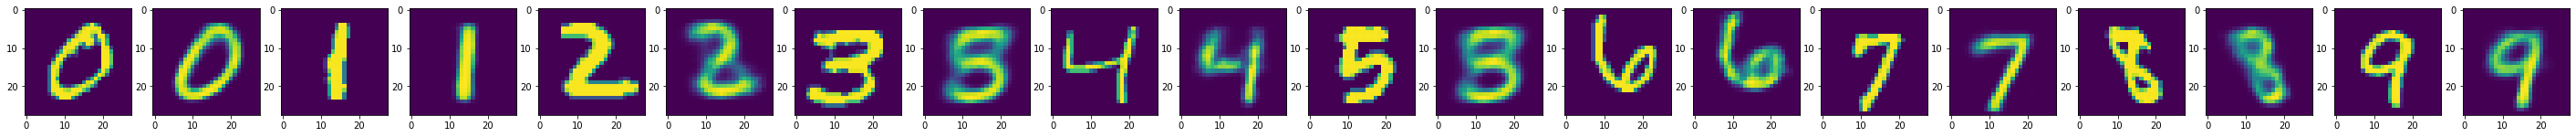

Epoch [10/15], Loss: 0.1340


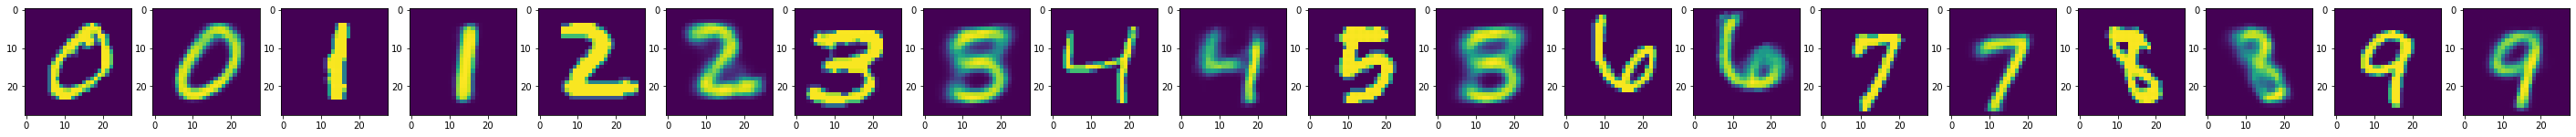

Epoch [11/15], Loss: 0.1411


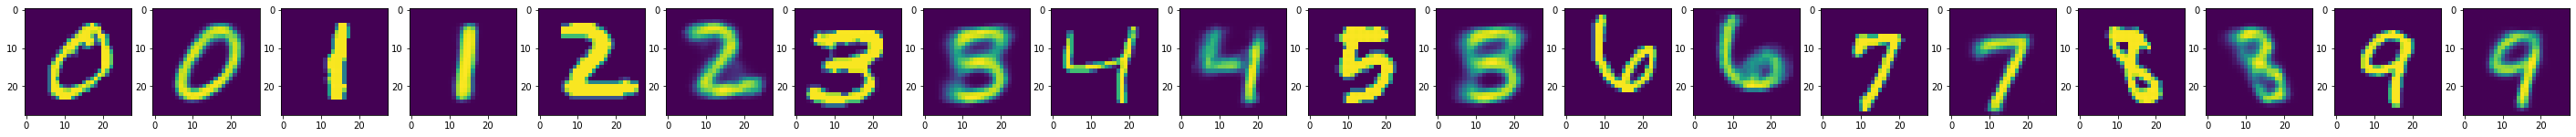

Epoch [12/15], Loss: 0.1395


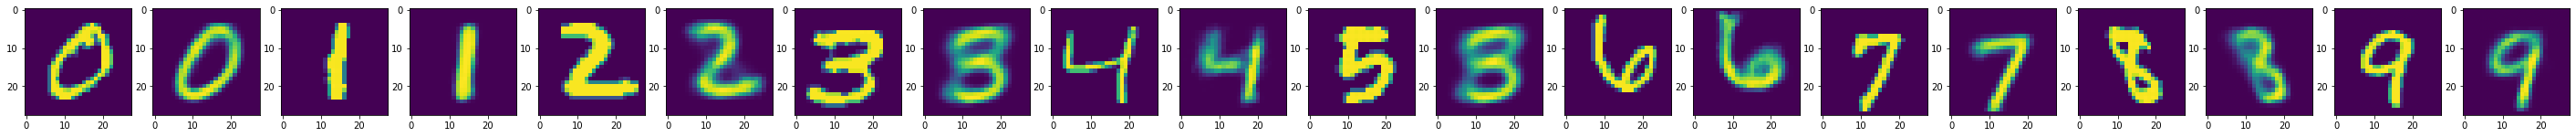

Epoch [13/15], Loss: 0.1363


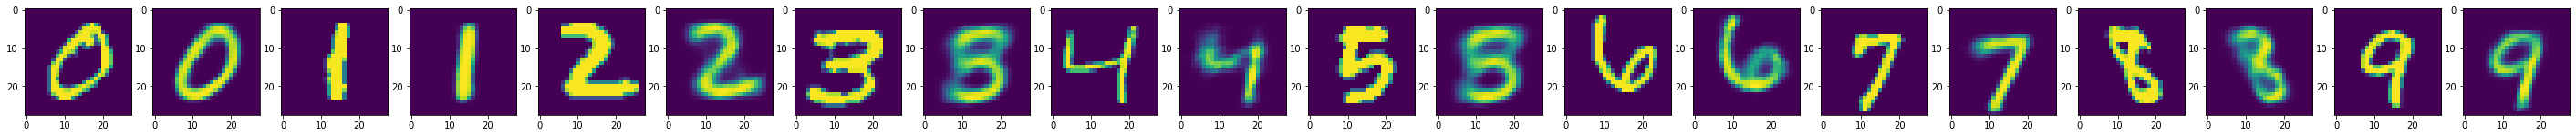

Epoch [14/15], Loss: 0.1384


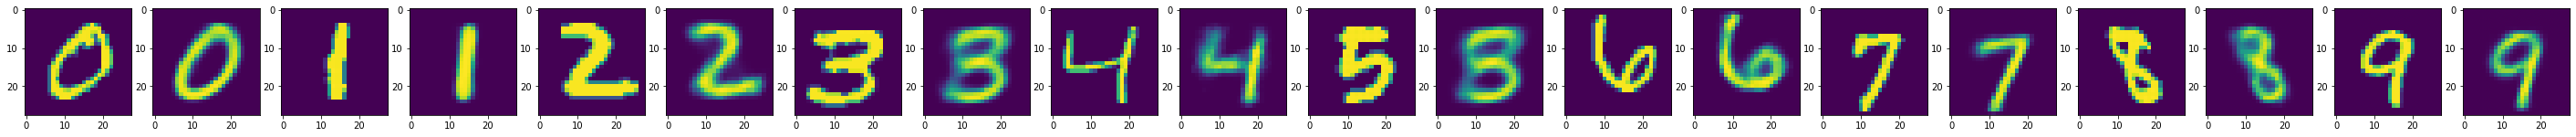

Epoch [15/15], Loss: 0.1386


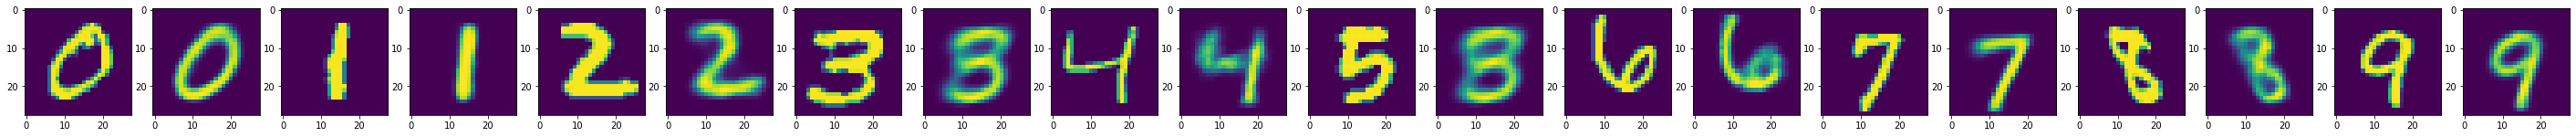

In [11]:
model=FCAE().to(device)
losses=train(model,train_loader,num_epochs,learning_rate)

Epoch [1/5], Loss: 0.1399


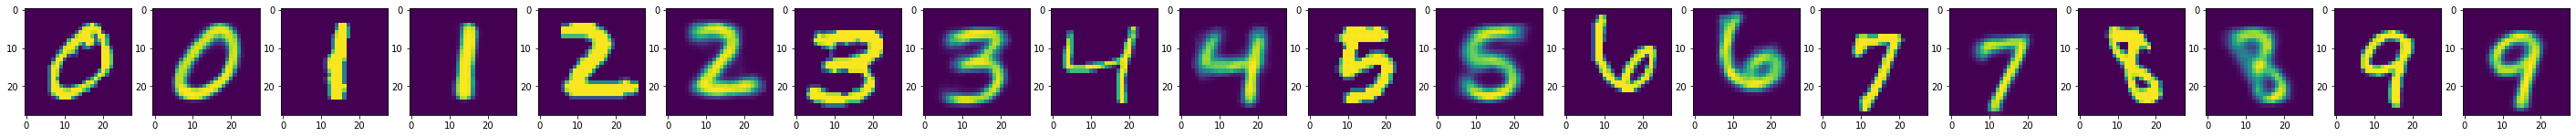

Epoch [2/5], Loss: 0.1396


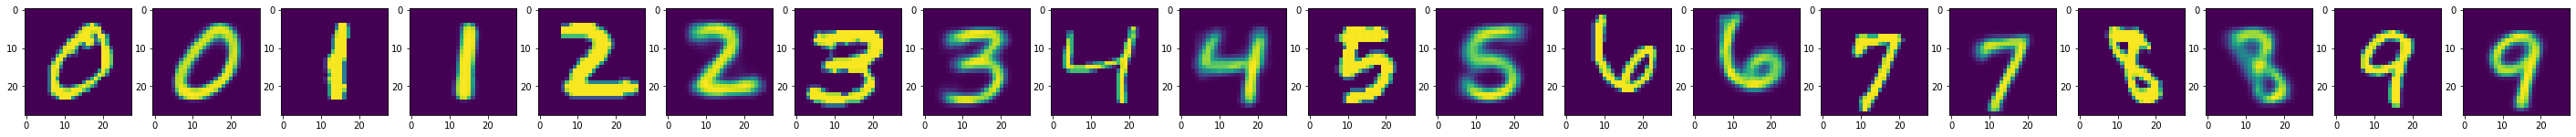

Epoch [3/5], Loss: 0.1367


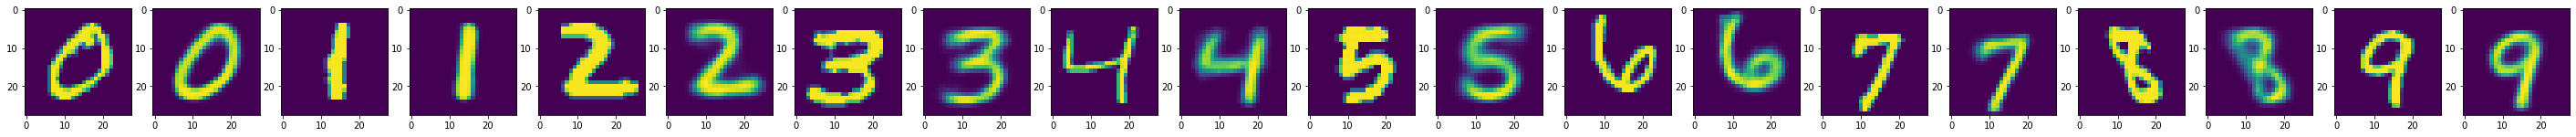

Epoch [4/5], Loss: 0.1371


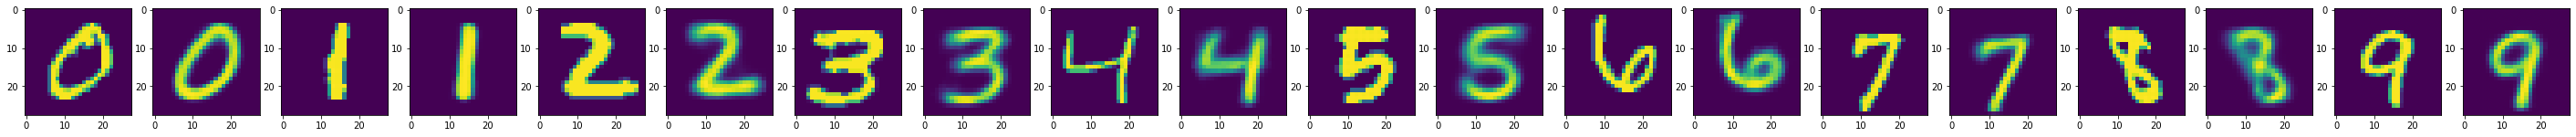

Epoch [5/5], Loss: 0.1370


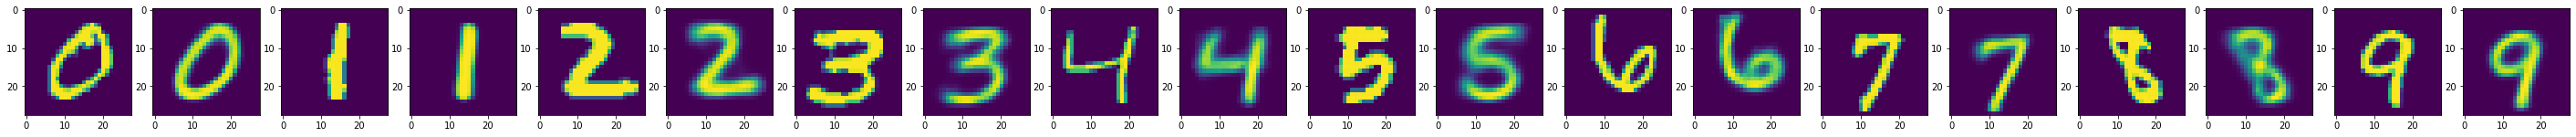

In [14]:
losses=train(model,train_loader,num_epochs=5,learning_rate=1e-4)

In [ ]:
evaluate(model,test_loader)

In [ ]:
plt.plot(losses)

In [ ]:
tens1=training_set[3][0]
test1=np.squeeze(tens1.numpy())
plt.imshow(test1)

In [ ]:
with torch.no_grad():
  tens1_reconstr=model.forward(tens1.to(device))
  test1_reconstr=np.squeeze(tens1_reconstr.cpu().numpy())
  plt.imshow(test1_reconstr)